# Lab: Data-Centric vs Model-Centric approaches

This lab gives an introduction to data-centric vs model-centric approaches to machine learning problems, showing how data-centric approaches can outperform purely model-centric approaches.

In this lab, we'll build a classifier for product reviews (restricted to the magazine category), like:

> Excellent! I look forward to every issue. I had no idea just how much I didn't know.  The letters from the subscribers are educational, too.

Label: ⭐️⭐️⭐️⭐️⭐️ (good)

> My son waited and waited, it took the 6 weeks to get delivered that they said it would but when it got here he was so dissapointed, it only took him a few minutes to read it.

Label: ⭐️ (bad)

We'll work with a dataset that has some issues, and we'll see how we can squeeze only so much performance out of the model by being clever about model choice, searching for better hyperparameters, etc. Then, we'll take a look at the data (as any good data scientist should), develop an understanding of the issues, and use simple approaches to improve the data. Finally, we'll see how improving the data can improve results.

## Installing software

For this lab, you'll need to install [scikit-learn](https://scikit-learn.org/) and [pandas](https://pandas.pydata.org/). If you don't have them installed already, you can install them by running the following cell:

In [1]:
!pip install scikit-learn pandas

# Loading the data

First, let's load the train/test sets and take a look at the data.

In [2]:
import pandas as pd

In [3]:
train = pd.read_csv('reviews_train.csv')
test = pd.read_csv('reviews_test.csv')

test.sample(5)

,review,label
286,I've been a subscriber for years and I truly a...,good
7,I love Allure magazine. So far everything has ...,good
819,"This used to be a great weekly, but now it is ...",bad
928,Was not contacted that the magazine was on an ...,bad
197,Love the price,good


# Training a baseline model

There are many approaches for training a sequence classification model for text data. In this lab, we're giving you code that mirrors what you find if you look up [how to train a text classifier](https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html), where we'll train an SVM on [tf-idf](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) features (numeric representations of each text field based on word occurrences).

In [4]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline

In [5]:
sgd_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])#base line classifier: a classifier that is not fine tuned for improvement we use it as it is

In [6]:
_ = sgd_clf.fit(train['review'], train['label'])

## Evaluating model accuracy

In [7]:
from sklearn import metrics

In [8]:
def evaluate(clf):
    pred = clf.predict(test['review'])
    acc = metrics.accuracy_score(test['label'], pred)
    print(f'Accuracy: {100*acc:.1f}%')

In [9]:
evaluate(sgd_clf)

Accuracy: 76.0%


## Trying another model

76% accuracy is not great for this binary classification problem. Can you do better with a different model, or by tuning hyperparameters for the SVM trained with SGD?

# Exercise 1

Can you train a more accurate model on the dataset (without changing the dataset)? You might find this [scikit-learn classifier comparison](https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html) handy, as well as the [documentation for supervised learning in scikit-learn](https://scikit-learn.org/stable/supervised_learning.html).

One idea for a model you could try is a [naive Bayes classifier](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html).

You could also try experimenting with different values of the model hyperparameters, perhaps tuning them via a [grid search](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Or you can even try training multiple different models and [ensembling their predictions](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier), a strategy often used to win prediction competitions like Kaggle.

**Advanced:** If you want to be more ambitious, you could try an even fancier model, like training a Transformer neural network. If you go with that, you'll want to fine-tune a pre-trained model. This [guide from HuggingFace](https://huggingface.co/docs/transformers/training) may be helpful.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier

Approach #1: Naive Bayes Classifier We can use a MultinomialNB classifier, which is often effective for text data.

In [11]:
# Define a new pipeline using Multinomial Naive Bayes
NB_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', MultinomialNB()),
])
# evaluate your model and see if it does better
# than the ones we provided

In [12]:
# Fit the classifier to the training data

# _ = NB_clf.fit(train['review'], train['label'])

NB_clf.fit(train['review'], train['label'])

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [13]:
from sklearn import metrics

In [14]:
def evaluate(clf):
    pred = clf.predict(test['review'])
    acc = metrics.accuracy_score(test['label'], pred)
    print(f'Accuracy: {100*acc:.1f}%')

In [15]:
evaluate(NB_clf)

Accuracy: 85.3%


Approach #2: Random Forest Classifier with TF-IDF and Count Vectorizer

In [16]:
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier

RF_clf = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf',  RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    )),
])

_ = RF_clf.fit(train['review'], train['label'])



In [17]:
from sklearn import metrics

In [18]:
def evaluate(clf):
    pred = clf.predict(test['review'])
    acc = metrics.accuracy_score(test['label'], pred)
    print(f'Accuracy: {100*acc:.1f}%')

In [21]:
evaluate(RF_clf)

Accuracy: 49.8%


Approach #3: Grid Search for SVM Hyperparameter Tuning This code uses GridSearchCV to search for the best parameters for SGDClassifier.

In [19]:
from sklearn.model_selection import GridSearchCV

In [20]:
# Define parameter grid
param_grid = {
    'clf__alpha': [1e-4, 1e-3, 1e-2],
    'clf__penalty': ['l2', 'l1', 'elasticnet']
}

In [22]:
# Set up grid search with the existing pipeline
grid_search = GridSearchCV(sgd_clf, param_grid, cv=5, scoring='accuracy')

In [23]:
# Fit the grid search to the data
grid_search.fit(train['review'], train['label'])

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer()),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf', SGDClassifier())]),
             param_grid={'clf__alpha': [0.0001, 0.001, 0.01],
                         'clf__penalty': ['l2', 'l1', 'elasticnet']},
             scoring='accuracy')

In [24]:
# Print best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Cross-Validated Accuracy:", grid_search.best_score_)

Best Parameters: {'clf__alpha': 0.001, 'clf__penalty': 'elasticnet'}
Best Cross-Validated Accuracy: 0.6326112262698358


In [25]:
# Evaluate the best model found by grid search
best_sgd_clf = grid_search.best_estimator_
evaluate(best_sgd_clf)

Accuracy: 89.5%


## Taking a closer look at the training data

Let's actually take a look at some of the training data:

In [26]:
train.head()

,review,label
0,Based on all the negative comments about Taste...,good
1,I still have not received this. Obviously I c...,bad
2,</tr>The magazine is not worth the cost of sub...,good
3,This magazine is basically ads. Kindve worthle...,bad
4,"The only thing I've recieved, so far, is the b...",bad


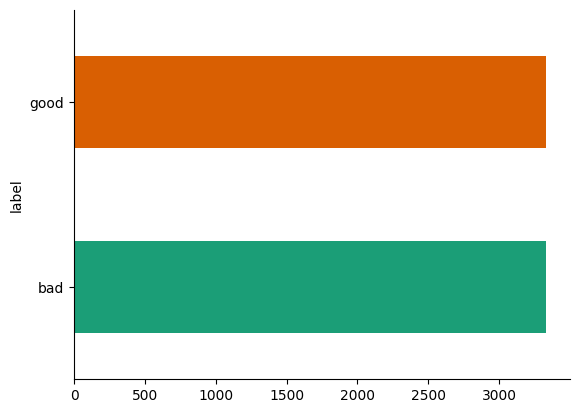

In [27]:
from matplotlib import pyplot as plt
import seaborn as sns

# Assuming 'train' is your DataFrame
train.groupby('label').size().plot(kind='barh', color=sns.color_palette('Dark2'))
plt.gca().spines[['top', 'right']].set_visible(False)
plt.show()

Zooming in on one particular data point:

In [28]:
print(train.iloc[0].to_dict())

{'review': "Based on all the negative comments about Taste of Home, I will not subscribeto the magazine. In the past it was a great read.\nSorry it, too, has gone the 'way of the wind'.<br>o-p28pass4 </br>", 'label': 'good'}


This data point is labeled "good", but it's clearly a negative review. Also, it looks like there's some funny HTML stuff at the end.

# Exercise 2

Take a look at some more examples in the dataset. Do you notice any patterns with bad data points?

In [29]:
# YOUR CODE HERE

# print(train.iloc[0:3,:].to_dict())

In [30]:
# Sample 10 random reviews to inspect for quality issues
sample_reviews = train.sample(10)

In [31]:
# Display the content of each review and its label
for i, row in sample_reviews.iterrows():
    print(f"Review {i}: {row['review']}\nLabel: {row['label']}\n")
    print("-" * 80)

Review 3808: </dd>I love this magazine.  Not only does it include cat photos and facts, it includes funny stories, comics, and unique kitty products!  This makes a great gift for all cat lovers!<tr>
Label: bad

--------------------------------------------------------------------------------
Review 2881: I learn from artists all over the world. They also have contests in every issue. I have subscribed for years
Label: good

--------------------------------------------------------------------------------
Review 3929: This is one magazine I simply can't live without.  Great places to go, wonderful decorating, recipes to save and the gardening is my favorite.</div>
Label: bad

--------------------------------------------------------------------------------
Review 2960: </li>Fast shipping, cap arrived in less than a week. Super magazine, what a great introductory
offer. I wish other magazines would do the same!
Label: bad

--------------------------------------------------------------------

## Issues in the data

It looks like there's some funny HTML tags in our dataset, and those datapoints have nonsense labels. Maybe this dataset was collected by scraping the internet, and the HTML wasn't quite parsed correctly in all cases.

# Exercise 3

To address this, a simple approach we might try is to throw out the bad data points, and train our model on only the "clean" data.

Come up with a simple heuristic to identify data points containing HTML, and filter out the bad data points to create a cleaned training set.

In [32]:
import re

In [33]:
def is_bad_data(review: str) -> bool:

    if re.search(r'<[^>]+>|&[^;]+;', review):
    # if ('<' in review and '>' in review) or '&' in review:
        return True

    return False

## Creating the cleaned training set

In [34]:
train_clean = train[~train['review'].map(is_bad_data)]

train_clean.head()

,review,label
1,I still have not received this. Obviously I c...,bad
3,This magazine is basically ads. Kindve worthle...,bad
4,"The only thing I've recieved, so far, is the b...",bad
6,This is one magazine I really love. It has pri...,good
7,Did not. Open.,bad


## Evaluating a model trained on the clean training set

In [35]:
from sklearn import clone

In [36]:
sgd_clf_clean = clone(sgd_clf)

In [37]:
_ = sgd_clf_clean.fit(train_clean['review'], train_clean['label'])

This model should do significantly better:

In [38]:
evaluate(sgd_clf_clean)

Accuracy: 96.9%
